In [5]:
import os
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import tensorly as tl
import numpy as np

In [6]:
MVBS_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_MVBS_envFromFile/'
MVBS_path = '../data/reproduced_MVBS_files/'
MVBS_file = '20150817-20151017_MVBS_time_from_Sv_rangeBin5_all.nc'

In [7]:
MVBS = xr.open_dataset(os.path.join(MVBS_path, MVBS_file))
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (ping_time, range_bin) float64 ...

In [8]:
#MVBS_PCP_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_PCP_envFromFile/'
MVBS_PCP_path = '../data/reproduced_MVBS_files/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_from_Sv_rangeBin5_rpca.nc'

In [9]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
MVBS_rpca

<xarray.Dataset>
Dimensions:    (date: 62, depth: 37, frequency: 3, hour: 144)
Coordinates:
  * date       (date) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
  * hour       (hour) float64 0.0 0.1667 0.3333 0.5 ... 23.33 23.5 23.67 23.83
Data variables:
    low_rank   (date, frequency, depth, hour) float64 ...
    sparse     (date, frequency, depth, hour) float64 ...

In [10]:
low_rank = MVBS_rpca['low_rank']
low_rank.shape

(62, 3, 37, 144)

In [11]:
n_observations, n_frequencies, n_depth_levels, n_pins = low_rank.shape

In [12]:
low_rank = low_rank.values.reshape([n_observations,-1])
low_rank.shape

(62, 15984)

In [13]:
low_rank_nonneg = low_rank - low_rank.min()

## Classic NMF

In [14]:
model = NMF(n_components=3, init='random', random_state=0)

In [15]:
H = model.fit_transform(low_rank_nonneg)
W = model.components_

In [16]:
(W.shape, H.shape)

((3, 15984), (62, 3))

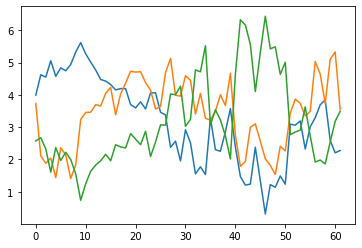

In [17]:
hlines = plt.plot(H)

In [18]:
W_reorg = W.reshape(3,3,37,144)

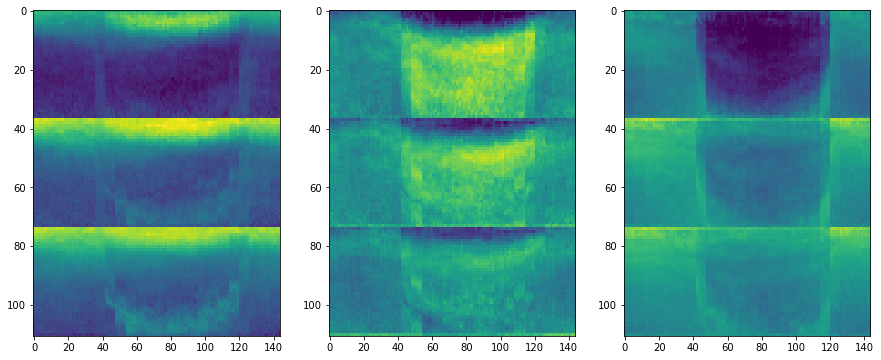

In [19]:
fig, ax = plt.subplots(1,3,figsize=(15,6))
for icomp in range(3):
    ax[icomp].imshow(tl.unfold(tl.tensor(W_reorg[icomp,:,:,:].squeeze()),mode=2).T,
                     aspect='auto')

## Check similarity between days

In [20]:
from scipy.spatial.distance import pdist, squareform

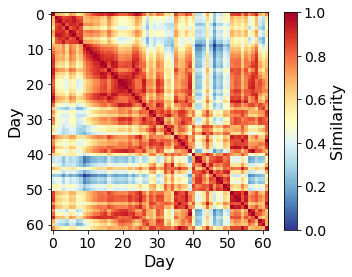

In [21]:
# Normalize the activation coefficients
k = H.T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
D = pdist(k_norm, 'euclidean')
D_square = squareform(D)
similarity_m = 1-D_square/D_square.max()

# Check similarity between any two days within the observation period
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plt.imshow(similarity_m,cmap='RdYlBu_r')
plt.xticks(np.arange(0,62,10),fontsize=14)
plt.yticks(np.arange(0,62,10),fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Day',fontsize=16)

cbaxes = fig.add_axes([0.8, 0.125, 0.03, 0.755]) 
cbar = plt.colorbar(cax = cbaxes)  
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_ylabel('Similarity', rotation=90, fontsize=16)
plt.show()


## Check reconstruction error

In [22]:
recon = (W.T@H.T).T

In [23]:
recon_da = xr.DataArray(np.moveaxis(recon.reshape([62, 3, 37, 144]),[0,1,2],[2,0,1]).reshape([3,37,-1]),
                        coords=[('frequency', MVBS_rpca['frequency']),
                                ('depth', MVBS_rpca['depth']),
                                ('ping_time', MVBS['ping_time'])])

In [24]:
rpca_da = xr.DataArray(np.moveaxis(MVBS_rpca['low_rank'].values,[0,1,2],[2,0,1]).reshape([3,37,-1])-
                       MVBS_rpca['low_rank'].values.min(),
                       coords=[('frequency', MVBS_rpca['frequency']),
                                ('depth', MVBS_rpca['depth']),
                                ('ping_time', MVBS['ping_time'])])

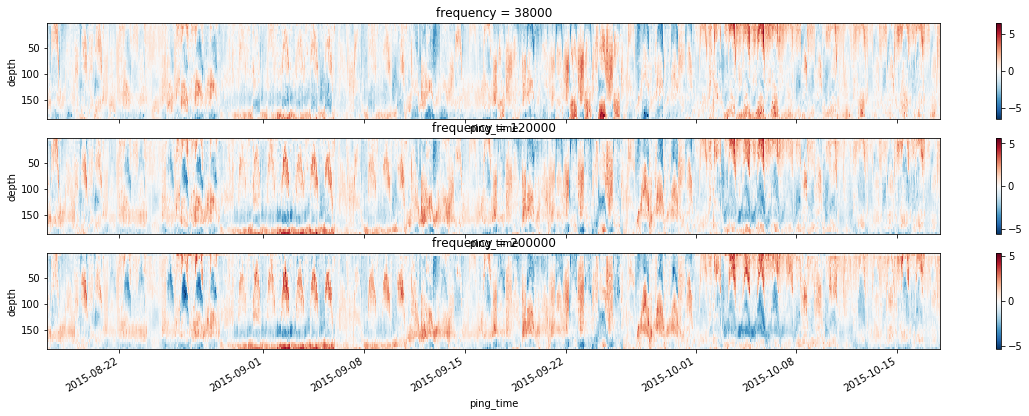

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(20,6), sharex=True)
for ifreq, freq in enumerate([38000,120000,200000]):
    (recon_da-rpca_da).sel(frequency=freq).plot(ax=ax[ifreq], yincrease=False)

# Smooth NMF

Next we run the smooth NMF which imposes smoothness (in time) on the activations by adding a Tikhonov regularization term on the gradient of $H$.

In [26]:
# perform this step once to install the ssnmf package
!pip install --upgrade git+https://github.com/valentina-s/ss-nmf.git

  Cloning https://github.com/valentina-s/ss-nmf.git to /private/var/folders/fq/3s4jskh93cv0__zlk6lw0l780000gn/T/pip-req-build-4aplcv1y
  Running command git clone -q https://github.com/valentina-s/ss-nmf.git /private/var/folders/fq/3s4jskh93cv0__zlk6lw0l780000gn/T/pip-req-build-4aplcv1y
  Created wheel for ss-nmf: filename=ss_nmf-VERSION-cp37-none-any.whl size=463761 sha256=936c163d42cf4a12e0f33bda5fbc96d99eadce80087ca1e9e6da7524a425ec6e
  Stored in directory: /private/var/folders/fq/3s4jskh93cv0__zlk6lw0l780000gn/T/pip-ephem-wheel-cache-yx2fw_rt/wheels/ee/7c/86/e2ef077ff7db547ab1ac9304320edcb62ea9df3420f458b54c
Successfully built ss-nmf


In [27]:
import ssnmf
model = ssnmf.smoothNMF(n_components=3, max_iter=2000, smoothness=5000000)

In [28]:
%%time
model.fit(low_rank_nonneg.T, init='random')

CPU times: user 1min 6s, sys: 27.9 s, total: 1min 34s
Wall time: 25 s


In [29]:
# set W and H
H = model.H.T
W = model.W.T

In [30]:
(W.shape, H.shape)

((3, 15984), (62, 3))

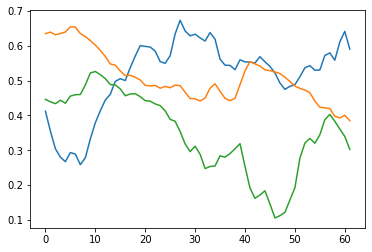

In [31]:
hlines = plt.plot(H)

In [32]:
low_rank_nonneg.shape

(62, 15984)

In [33]:
W_reorg = W.reshape(3,3,37,144)

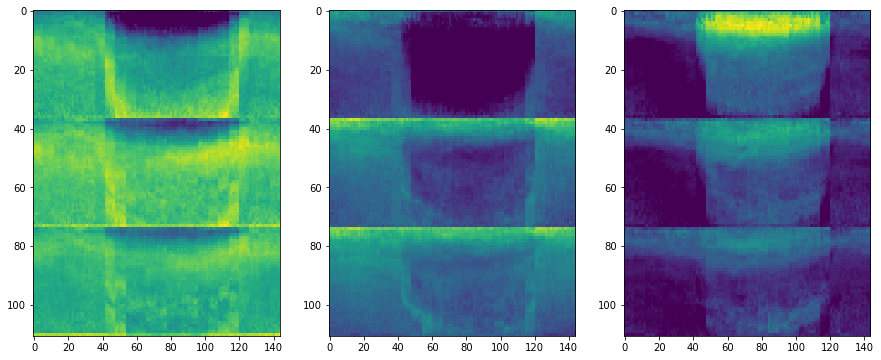

In [34]:
fig, ax = plt.subplots(1,3,figsize=(15,6))
for icomp in range(3):
    ax[icomp].imshow(tl.unfold(tl.tensor(W_reorg[icomp,:,:,:].squeeze()),mode=2).T,
                     aspect='auto')

## Check similarity between days

In [35]:
from scipy.spatial.distance import pdist, squareform

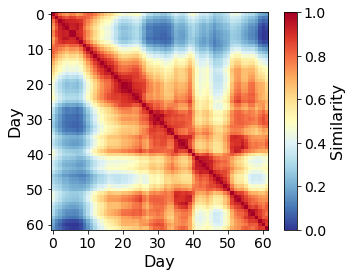

In [36]:
# Normalize the activation coefficients
k = H.T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
D = pdist(k_norm, 'euclidean')
D_square = squareform(D)
similarity_m = 1-D_square/D_square.max()

# Check similarity between any two days within the observation period
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plt.imshow(similarity_m,cmap='RdYlBu_r')
plt.xticks(np.arange(0,62,10),fontsize=14)
plt.yticks(np.arange(0,62,10),fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Day',fontsize=16)

cbaxes = fig.add_axes([0.8, 0.125, 0.03, 0.755]) 
cbar = plt.colorbar(cax = cbaxes)  
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_ylabel('Similarity', rotation=90, fontsize=16)
plt.show()

## Check reconstruction error

In [37]:
recon = (W.T@H.T).T


In [38]:
recon_da = xr.DataArray(np.moveaxis(recon.reshape([62, 3, 37, 144]),[0,1,2],[2,0,1]).reshape([3,37,-1]),
                        coords=[('frequency', MVBS_rpca['frequency']),
                                ('depth', MVBS_rpca['depth']),
                                ('ping_time', MVBS['ping_time'])])

In [39]:
rpca_da = xr.DataArray(np.moveaxis(MVBS_rpca['low_rank'].values,[0,1,2],[2,0,1]).reshape([3,37,-1])-
                       MVBS_rpca['low_rank'].values.min(),
                       coords=[('frequency', MVBS_rpca['frequency']),
                                ('depth', MVBS_rpca['depth']),
                                ('ping_time', MVBS['ping_time'])])

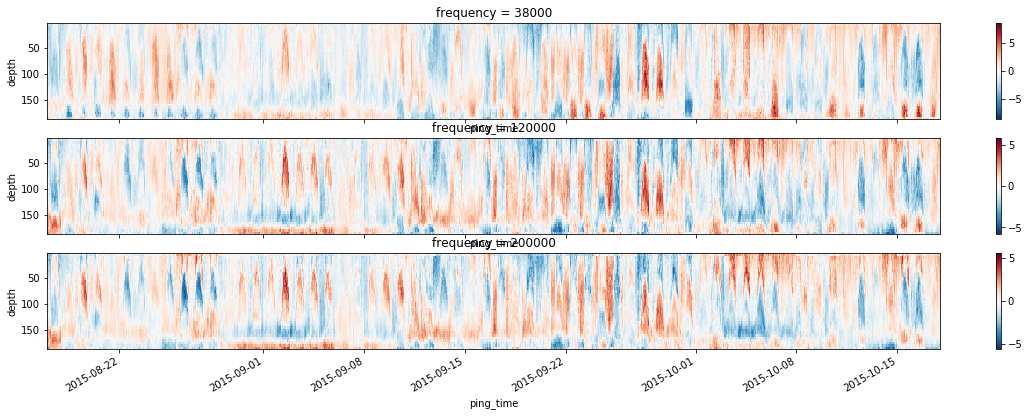

In [40]:
fig, ax = plt.subplots(3, 1, figsize=(20,6), sharex=True)
for ifreq, freq in enumerate([38000,120000,200000]):
    (recon_da-rpca_da).sel(frequency=freq).plot(ax=ax[ifreq], yincrease=False)